In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from committee_learning.ode import SphericalSquaredActivationODE
from committee_learning.initial_conditions import RandomNormalInitialConditions, SymmetricInitialConditions
from committee_learning.simulation import NormalizedSphericalConstraintSimulation
from committee_learning.result import SquareODEResult, SimulationResult
import numpy as np
from tqdm import tqdm

d = 10000
p = 1
k = 1
alpha = 0.1
noise = 0.#1e-3
dt = 1e-4
log_time = 2
id_n = 56
ic_seed = 8

# The goal is to fix always the same initial conditions and then do many runs to see what happens
# # Just random
# ic = RandomNormalInitialConditions(p,k,d,spherical=True, seed=ic_seed)
# Wteacher, W0 = ic.Wteacher, ic.W0
# extra_string = ''

# Ortogonal
ic = SymmetricInitialConditions(p = p, k = k, epsilon=0., q0=1., seed = ic_seed)
Wteacher, W0 = ic.weights(d)
extra_string = '-orthogonal'

### Simulations

In [3]:
sim_times = []
sim_risks = []
for id in tqdm(range(id_n)):
  sim = NormalizedSphericalConstraintSimulation(d,p,k,noise,Wteacher,alpha*p,'square',W0)
  # print(f'Simulating id = {id}')
  simr = SimulationResult(initial_condition=f'spherical-sde-test-browninian{extra_string}-icseed{ic_seed}', id=id)
  simr.from_file_or_run(sim,2+np.log10(sim.d),path='computation-database/sim/',force_read=True)
  if id == 0:
    sim_times = np.array(simr.steps)/d
  sim_risks.append(simr.macroscopic_risk())

sim_risks = np.array(sim_risks)

100%|██████████| 56/56 [00:16<00:00,  3.41it/s]


### ODE

In [4]:
ode = SphericalSquaredActivationODE(p,k,noise,alpha*p,ic.P,ic.Q,ic.M,dt)
oder = SquareODEResult(initial_condition=f'spherical-phase-retrivial-ode{extra_string}-icseed{ic_seed}', id=ic_seed)
oder.from_file_or_run(ode, log_time, path='computation-database/ode/')

### SDE

In [28]:
from committee_learning.sde.phase_retrivial import SphericalPhaseRetrivialSDE, NaiveSphericalPhaseRetrivialSDE

sde_times = []
sde_risks = []

for id in tqdm(range(id_n)):
  sde = SphericalPhaseRetrivialSDE(noise, alpha*p, ic.P, ic.Q, ic.M, d, dt, seed=id)
  sder = SquareODEResult(initial_condition=f'spherical-phase-retrivial-sde{extra_string}-icseed{ic_seed}', id=id)
  sder.from_file_or_run(sde, log_time, path='computation-database/sde/')
  if id == 0:
    sde_times = np.array(sder.times)
  sde_risks.append(sder.risks)

sde_risks = np.array(sde_risks)

naivesde_times = []
naivesde_risks = []

for id in tqdm(range(id_n)):
  naivesde = NaiveSphericalPhaseRetrivialSDE(noise, alpha*p, ic.P, ic.Q, ic.M, d, dt, seed=id)
  naivesder = SquareODEResult(initial_condition=f'naive-spherical-phase-retrivial-sde{extra_string}-icseed{ic_seed}', id=id)
  naivesder.from_file_or_run(naivesde, log_time, path='computation-database/sde/', show_progress=False, force_run=True)
  if id == 0:
    naivesde_times = np.array(naivesder.times)
  naivesde_risks.append(np.array(naivesder.risks))
  # print(naivesde_risks)

naivesde_risks = np.array(naivesde_risks)

100%|██████████| 56/56 [2:53:51<00:00, 186.27s/it]  


In [45]:
from committee_learning.utilities import plot_style
import matplotlib.pyplot as plt

# print(np.array(naivesde_risks))
with plot_style():
  fig, ax = plt.subplots(figsize=(3,3))
  ax.set_xscale('log')
  ax.set_yscale('log')
  ax.set_xlim(1e-0,1e2)
  ax.set_ylim(1e-2,2.5)
  ax.set_xlim(5,50)
  ax.set_ylim(1.75,2.2)
  ax.plot(sim_times, sim_risks.T,ls='-',lw=1.,marker='',ms=5.,c='blue',alpha=0.09)
  ax.plot(sim_times, np.mean(sim_risks, axis = 0), label =f'Sim. Average', ls='-',lw=1.7,marker='',ms=2.,c='blue')

  ax.plot(oder.times, oder.risks, label = 'ODE', ls='-',lw=1.,marker='',ms=2.,c='yellow')

  ax.plot(sde_times, sde_risks.T, ls='-',lw=1.,marker='',ms=2.,c='green', alpha=0.09)
  ax.plot(sde_times, np.mean(sde_risks, axis = 0), label =f'Itô SDE average', ls='-',lw=1.7,marker='',ms=2.,c='green')

  ax.plot(naivesde_times, naivesde_risks.T, ls='-',lw=1.,marker='',ms=2.,c='orange', alpha=0.09)
  ax.plot(naivesde_times, np.mean(naivesde_risks, axis = 0), label =f'Naive SDE average', ls='-',lw=1.7,marker='',ms=2.,c='orange')
  ax.legend()
  fig.savefig(f'figures/sde_naive.pdf', format = 'pdf', bbox_inches = 'tight')

**Probably there is so much noise after the drop because we are entering in what Ben Arus calls "balistic phase", and the Brownian motion it's not there anymore.**

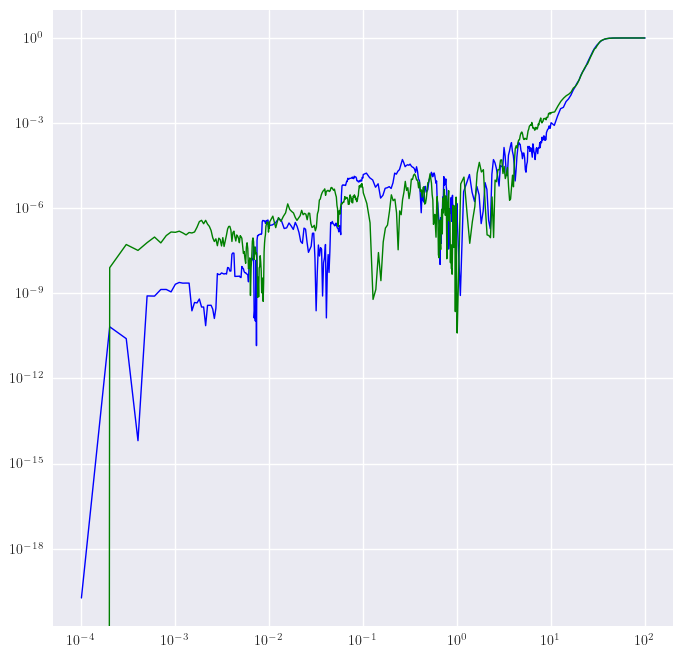

In [ ]:
with plot_style():
  fig, ax = plt.subplots(figsize=(8,8))
  ax.set_xscale('log')
  ax.set_yscale('log')
  # ax.set_xlim(1,100)
  # ax.set_ylim(.00001,1.6)

  ax.plot(np.array(simr.steps)/d, abs(np.reshape(np.array(simr.Ms),(500,)))**2, label = 'sim', ls='-',lw=1.,marker='',ms=2.,c='blue')
  ax.plot(oder.times, abs(np.reshape(np.array(oder.Ms),(513,)))**2, label = 'ODE', ls='-',lw=1.,marker='',ms=2.,c='yellow')
  ax.plot(oder.times, abs(np.reshape(np.array(sder.Ms),(513,)))**2, label = 'SDE', ls='-',lw=1.,marker='',ms=2.,c='green')
  plt.show()